# Components

- LLMs are trained on enormous bodies of data to learn general knowledge; may not be on relevant and up-to-date data. RAG solves this by finding and retrieving relevant information from your data and giving that to the LLM. -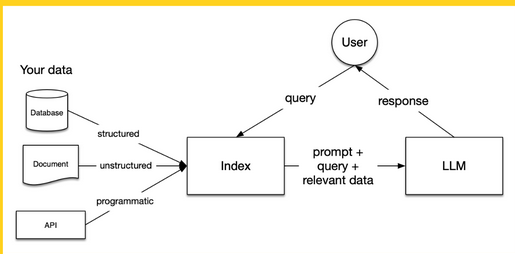


# 5 key stages within RAG

- Loading: refers to getting your data from where it lives- whether it's text files, PDFs, another website, a database or an API - into your workflow.

- Indexing: this means creating a data structure that allows for querying the data. For LLMs, this nearly always means creating vector embeddings.

- Storing: Once your data is indexed you will want to store your index, as well as other metadata, to avoid having to re-index it.

- Querying: for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.

- Evaluation: a critical step in any flow is checking how effective it is relative to other strategies, or when you make changes. Evaluation provides objective measures of how accurate, faithful and fast your responses to queries are.

## Loading and embedding documents

1. SimpleDirectoryReader: A built-in loader for various file types froom a local directory.
2. LlamaParse: LlamaParse, LlamaIndex's official tool for PDF parsing.
3. LlamaHub: A registry of hundreds of data-loading libraries to ingest data from any source.


In [1]:
from llama_index.core import SimpleDirectoryReader
reader=SimpleDirectoryReader(input_dir='D:\9\huggingfaceagents-course\smolagents')
documents=reader.load_data()

- After loading we need to break them into smaller pieces called _Node Objects_. A Node is a chunk of text from the original document that's easier for the AI to work with, while it still has references to the original Document object.

- The _IngestionPipeline_ helps us to create these nodes through 2 key transformations.

1. SentenceSplitter: breaks down documents into manageable chunks by splitting them at natural sentence boundaries.
2. HuggingFaceEmbedding: converts each chunk into numerical embeddings- vector representations that capture the semantic meaning in a way AI can process efficiently.


In [3]:
from llama_index.core import Document
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.ingestion import IngestionPipeline
pipeline=IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_overlap=0),
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ]
)
nodes=await pipeline.arun(documents=[Document.example()])

model.safetensors:  35%|###5      | 73.4M/207M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/repos/65/7a/657aa25dcd01b516ff64ac04ad0411983498b446edae5e07a99d03bffc6faeca/3c9f31665447c8911517620762200d2245a2518d6e7208acc78cd9db317e21ad?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1750139354&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MDEzOTM1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy82NS83YS82NTdhYTI1ZGNkMDFiNTE2ZmY2NGFjMDRhZDA0MTE5ODM0OThiNDQ2ZWRhZTVlMDdhOTlkMDNiZmZjNmZhZWNhLzNjOWYzMTY2NTQ0N2M4OTExNTE3NjIwNzYyMjAwZDIyNDVhMjUxOGQ2ZTcyMDhhY2M3OGNkOWRiMzE3ZTIxYWQ%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=qTBhw9sJbFqd8CjbwBoqbfnGQrNFrlZSBqQUbtQThXf9rFrKqS67iPr1fJzQFFZfRwiaJzhDdqI-oPYFXfh%7EeMYDld4j%7EuEE-gfEjFmhAOYDGR5TTnp25w8kTL4Z5zuSs0TXmQFeBlWnIjx0EFPns7wBEpreSoq%7EFKJCsqSaDonFCJgPiUIgLiR5vJ%7EiwiWAnK9-4NMdoEEdTTfMQ4XB3fAMEt38OicbCRWdMVHuCClCd8mOaZz89BMjjQQBFFPPeho

model.safetensors:  46%|####6     | 115M/249M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Storing and indexing documents

- After creating our Node objects we need to index them to make them searchable, but before that we need to store them.

- we can directly attach a vector store to the pipeline to populate it.


In [4]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
db=chromadb.PersistentClient(path="./alfred_chroma_db")
chroma_collection=db.get_or_create_collection("alfred")
vector_store=ChromaVectorStore(chroma_collection=chroma_collection)
pipeline=IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_size=25,chunk_overlap=0),
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    ],
    vector_store=vector_store,
)

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
embed_model=HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
index=VectorStoreIndex.from_vector_store(vector_store,embed_model=embed_model)

## Querying a VectorStoreIndex with prompts and LLMs

- we need to convert it to a query interface.
  1. as_retriever: For basic document retrieval, returning a list of NodeWithScore objects with similarity scores.
  2. as_query_engine: For single question-answer interactions, returning a written response.
  3. as_chat_engine: For conversational interactions that maintain memory across multiple messages, returning a written response using chat history and indexed content.


In [6]:
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
llm=HuggingFaceInferenceAPI(model_name="Qwen/Qwen2.5-Coder-32B-Instruct")
query_engine=index.as_query_engine(
    llm=llm,
    response_mode="tree_summarize",
)
query_engine.query("What is the meaning of life?")

Response(response='Empty Response', source_nodes=[], metadata=None)

## Response Processing

- The query engine also uses a ResponeSynthesizer as a strategy to process the response.
- 3 main strategies:
  1. refine: create and refine an answer by sequentially going through each retrieved text chunk. This makes a separate LLM call per Node.
  2. compact: similar to refining but concatenating the chunks beforehand, resulting in fewer LLM calls.
  3. tree_summarize: create a detailed answer by going through each retrieved text chunk and creating a tree structure of the answer.

## Evaluation and observability:

- Llamaindex provides built in evaluation tools to assess response quality. These evaluators leverage LLMs to analyze responses across different dimensions. 3 main evaluators:
  1. FaithfulnessEvaluator: Evaluates the faithfulness of the answer by checking if the answer is supported by the context.
  2. AnswerRelevancyEvaluator: Evaluate the relevance of the answer by checking if the answer is relevant to the question.
  3. CorrectnessEvaluator: Evaluate the correctness of the answer by checking if the answer is correct.


In [7]:
from llama_index.core.evaluation import FaithfulnessEvaluator
evaluator=FaithfulnessEvaluator(llm=llm)
response=query_engine.query("What battles took place in New York City in the American Revolution?")
eval_result=evaluator.evaluate_response(response=response)
eval_result.passing

False

In [9]:
import llama_index
import os

PHOENIX_API_KEY = os.environ.get("PHOENIX_API_KEY")
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix",
    endpoint="https://llamatrace.com/v1/traces"
)